In [1]:
pip install shap

In [2]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [7]:
!pip install imblearn

In [11]:
import sys

In [13]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [294]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import pydot

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import fmin, tpe

from scipy import optimize

%matplotlib inline
plt.style.use('ggplot')

In [295]:
shap.initjs()

# EDA

## Import Data

In [312]:
df = pd.read_csv("C:/Users/New User/Desktop/Fraud/data/fraudTrain.csv")
df = df.sample(n=100000) #sampling 100k from 1m dataset
df.shape

(100000, 23)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 114159 to 1241322
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   trans_date_trans_time  100000 non-null  object 
 2   cc_num                 100000 non-null  int64  
 3   merchant               100000 non-null  object 
 4   category               100000 non-null  object 
 5   amt                    100000 non-null  float64
 6   first                  100000 non-null  object 
 7   last                   100000 non-null  object 
 8   gender                 100000 non-null  object 
 9   street                 100000 non-null  object 
 10  city                   100000 non-null  object 
 11  state                  100000 non-null  object 
 12  zip                    100000 non-null  int64  
 13  lat                    100000 non-null  float64
 14  long                   100000 

In [112]:
df.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,6.475276e+05,4.119842e+17,69.232722,48677.496240,38.540543,-90.167733,9.009193e+04,1.349214e+09,38.541789,-90.168995,0.005640
std,3.745535e+05,1.300986e+18,138.566644,26903.649837,5.076507,13.767279,3.059389e+05,1.284775e+07,5.111508,13.780796,0.074888
min,1.000000e+00,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.325376e+09,19.037694,-166.629875,0.000000
25%,3.225738e+05,1.800365e+14,9.540000,26041.000000,34.668900,-96.786900,7.410000e+02,1.338718e+09,34.760984,-96.851397,0.000000
50%,6.477765e+05,3.520550e+15,47.120000,48088.000000,39.371600,-87.456900,2.435000e+03,1.349220e+09,39.370462,-87.363268,0.000000
75%,9.707515e+05,4.642255e+15,82.480000,72011.000000,41.846700,-80.138100,2.032800e+04,1.359296e+09,41.938572,-80.195296,0.000000
max,1.296665e+06,4.992346e+18,11694.980000,99783.000000,66.693300,-67.950300,2.906700e+06,1.371817e+09,67.441518,-66.958751,1.000000


In [113]:
# Define all features
orig_feats = [col for col in df.columns if 'is_fraud' not in col]

len(orig_feats)

22

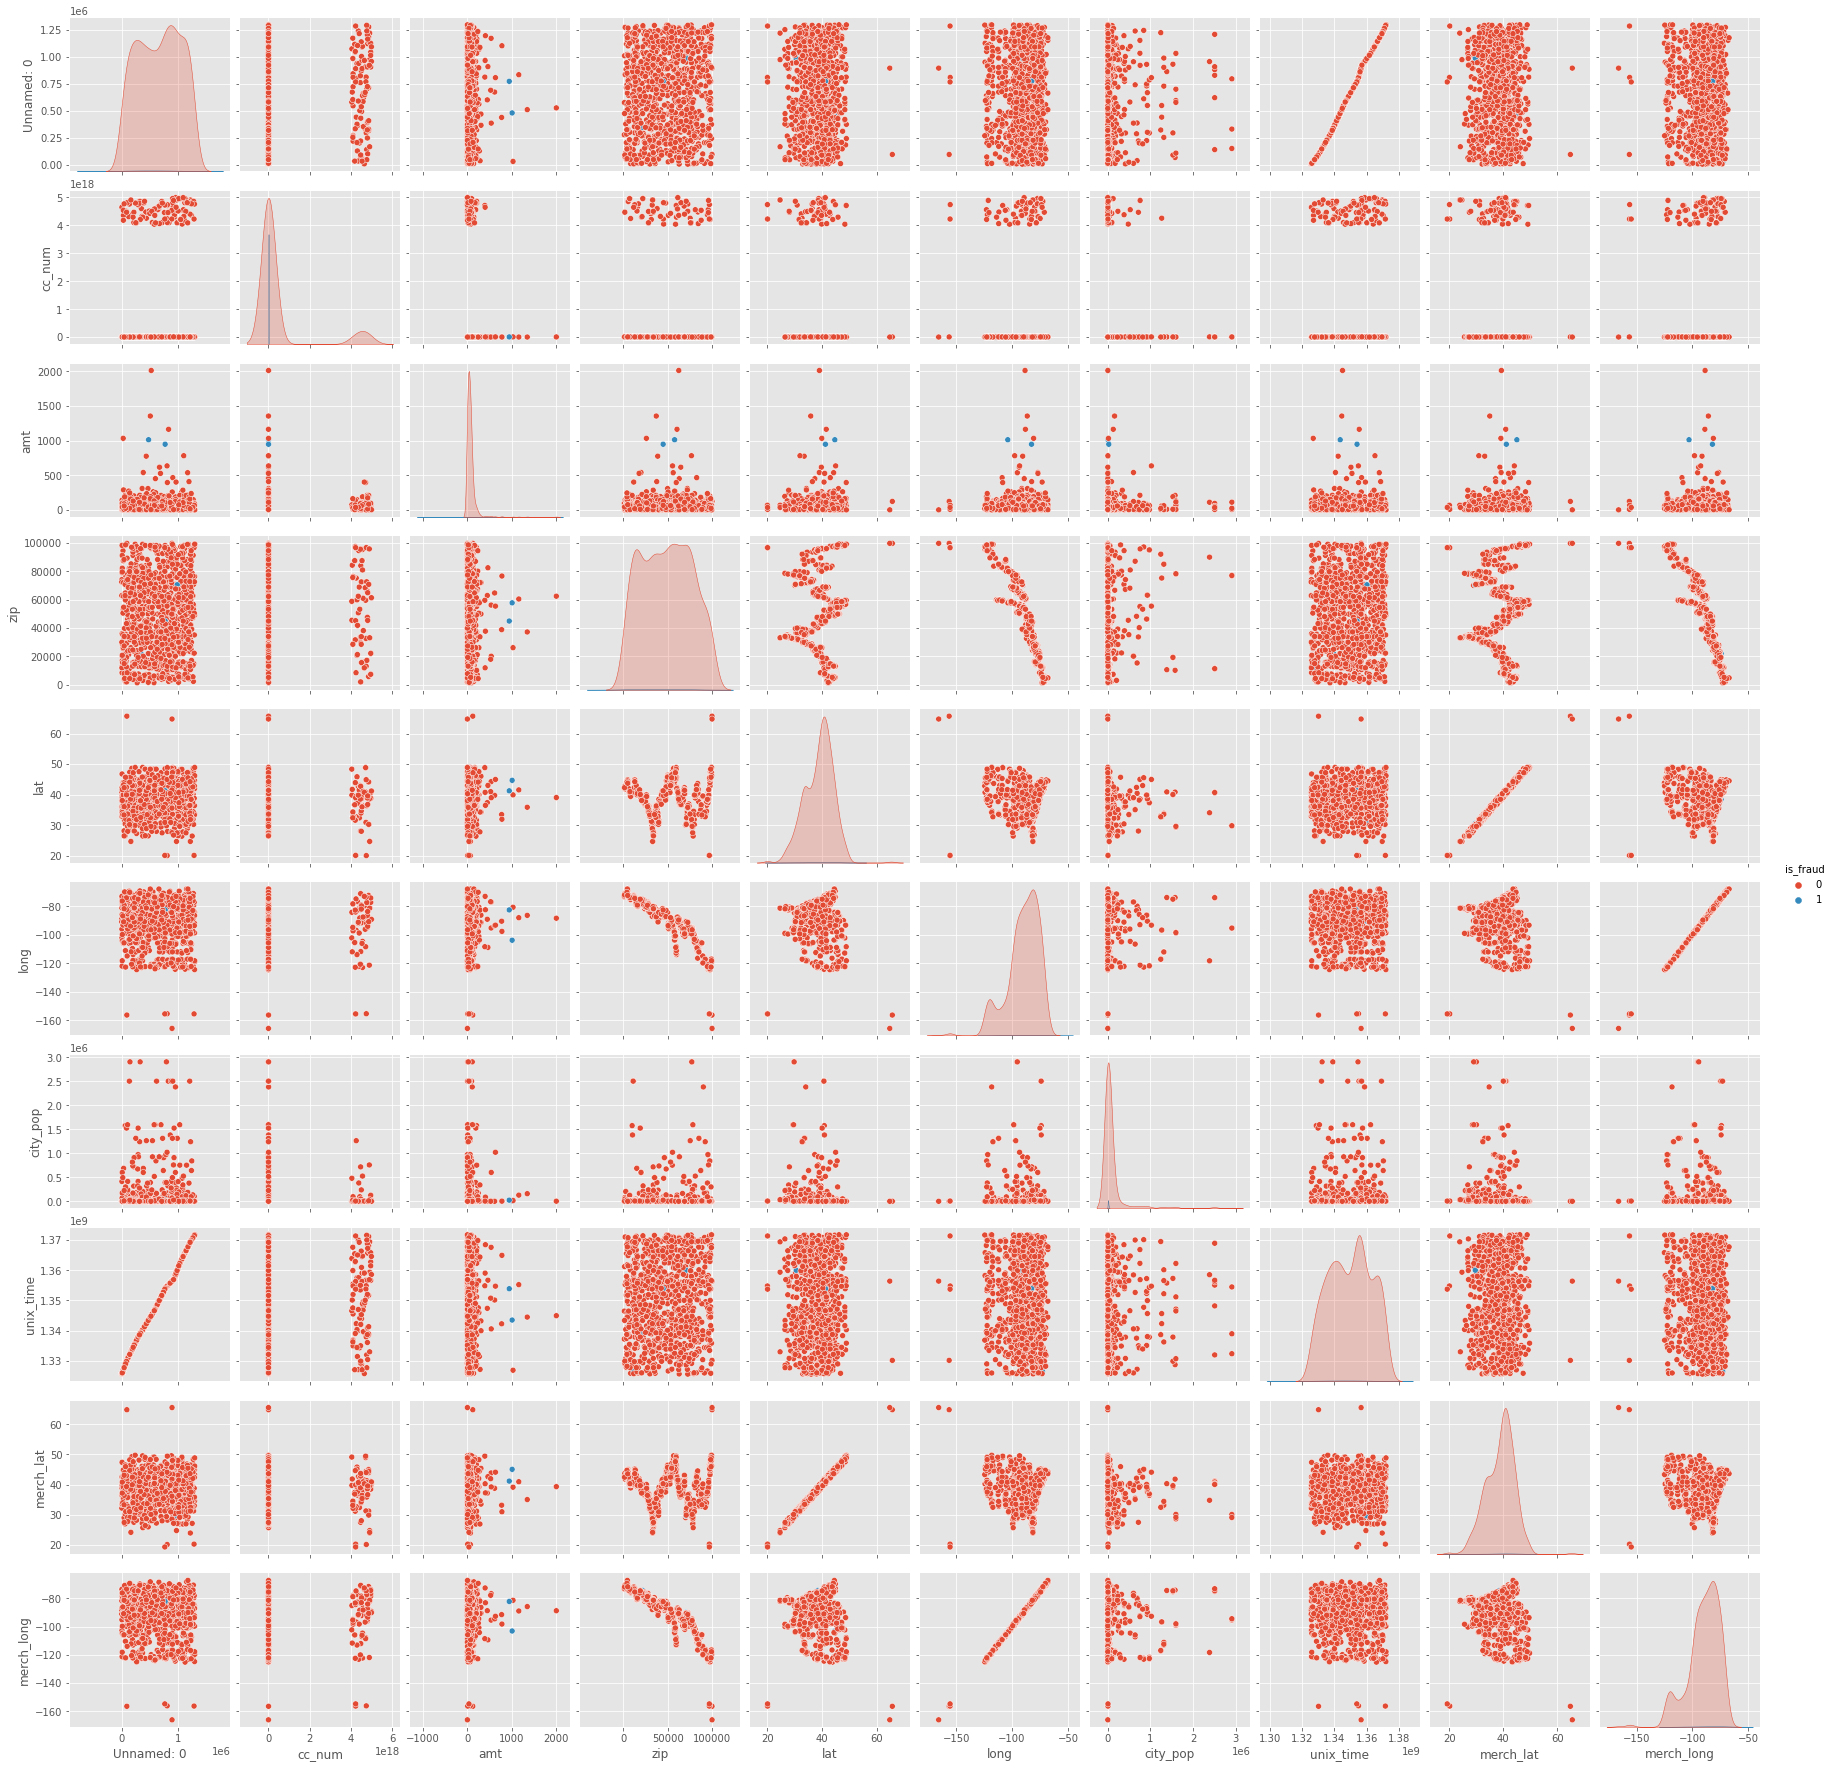

In [114]:
sns.pairplot(df[orig_feats[:22]+['is_fraud']].sample(1000, random_state=1), hue='is_fraud')

In [115]:
target = 'is_fraud'

In [116]:
# Only 0.58% of the dataset is labelled as fraud
df[target].value_counts(normalize=True)

0    0.99436
1    0.00564
Name: is_fraud, dtype: float64

<AxesSubplot:>

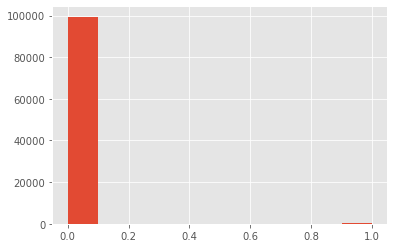

In [117]:
df[target].hist()

In [118]:
# correlation matrix with numeric values
# features with strongest correlation: amt
df.corr()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
Unnamed: 0,1.000000,-0.006121,-0.003088,0.001500,0.001590,-0.001639,-0.002446,0.998960,0.001299,-0.001544,-0.001643
cc_num,-0.006121,1.000000,0.004183,0.042460,-0.058765,-0.048593,-0.009510,-0.005992,-0.058565,-0.048847,-0.000964
amt,-0.003088,0.004183,1.000000,0.008145,0.001261,-0.008077,0.008651,-0.003138,0.001073,-0.007980,0.255263
zip,0.001500,0.042460,0.008145,1.000000,-0.113231,-0.908966,0.079187,0.001408,-0.112340,-0.908219,-0.006154
lat,0.001590,-0.058765,0.001261,-0.113231,1.000000,-0.019946,-0.154215,0.001663,0.993610,-0.019820,0.005140
long,-0.001639,-0.048593,-0.008077,-0.908966,-0.019946,1.000000,-0.051902,-0.001600,-0.019963,0.999123,0.003596
city_pop,-0.002446,-0.009510,0.008651,0.079187,-0.154215,-0.051902,1.000000,-0.002620,-0.153174,-0.051795,0.000962
unix_time,0.998960,-0.005992,-0.003138,0.001408,0.001663,-0.001600,-0.002620,1.000000,0.001376,-0.001507,-0.001947
merch_lat,0.001299,-0.058565,0.001073,-0.112340,0.993610,-0.019963,-0.153174,0.001376,1.000000,-0.019823,0.005359
merch_long,-0.001544,-0.048847,-0.007980,-0.908219,-0.019820,0.999123,-0.051795,-0.001507,-0.019823,1.000000,0.003610


<AxesSubplot:>

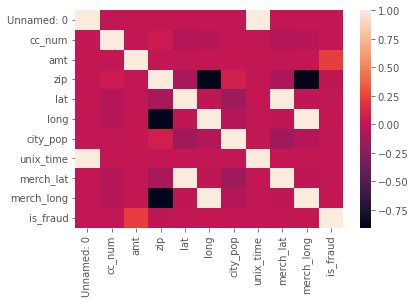

In [297]:
# correlation matrix with heatmap
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# Train, Test, Split

In [313]:
df = df.drop('Unnamed: 0', 1)
df = df.drop('trans_date_trans_time', 1)
df = df.drop('dob', 1)

In [314]:
X = df[['cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']]
y = df['is_fraud']

In [298]:
# CONVERTING DATETIME STRING TO DATETIME

current_date = dt.datetime.now()

print("Original date and time object:", current_date)


df['trans_date_trans_time'] = int(current_date.strftime("%Y%m%d%H%M%S"))

Original date and time object: 2022-02-25 00:08:11.732135


In [306]:
gender_M_1 = df['gender'] == 'M'
df[gender_M_1] = 1

In [307]:
gender_M_1 = df['gender'] == 'F'
df[gender_M_1] = 0

In [308]:
X = df[['trans_date_trans_time', 'gender', 'trans_num', 'dob', 'cc_num', 'amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']]
y = df['is_fraud']

In [241]:
df['merchant'] = pd.to_numeric('merchant', errors='coerce')
df['category'] = pd.to_numeric('category', errors='coerce')
df['first'] = pd.to_numeric('first', errors='coerce')
df['last'] = pd.to_numeric('last', errors='coerce')

In [281]:
# Define all features
orig_feats = [col for col in df.columns if 'is_fraud' not in col]

In [282]:
X = df[orig_feats]
y = df['is_fraud']
y=y.astype('int')


In [315]:
# Use stratify to ensure samples of fraud label are in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75000, 9) (25000, 9) (75000,) (25000,)


In [316]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

The score for kNN is
Training:  99.45%
Test set:  99.38%


In [228]:
y_train.value_counts(normalize=True)

0    0.994267
1    0.005733
Name: is_fraud, dtype: float64

In [229]:
y_test.value_counts(normalize=True)

0    0.99428
1    0.00572
Name: is_fraud, dtype: float64

In [317]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

The score for logistic regression is
Training:  99.42%
Test set:  99.42%


In [ ]:
y_true =

y_pred = 

# Modeling

# Predicitng All Zeros
What is the AUC when all 0's are predicted?

In [318]:
naive_preds = np.zeros(y_test.shape[0])
len(naive_preds)

25000

In [319]:
roc_auc_score(y_test, naive_preds)

0.5

In [320]:
print(classification_report(y_test, naive_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     24855
           1       0.00      0.00      0.00       145

    accuracy                           0.99     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.99      0.99      0.99     25000



# Naive Models
Use cross validation and train naive models to see AUC scores and select model

In [321]:
num_boost_rounds = 1000
early_stopping_rounds = 10

initial_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [322]:
# define class weights
# w = {0:1, 1:99}
logit_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

In [159]:
logit_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5))

In [323]:
rf_cv = cross_val_score(estimator=RandomForestClassifier(),
                         X=X_train, 
                         y=y_train,
                         scoring='roc_auc',
                         cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

In [324]:
xgb_cv = cross_val_score(estimator=XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                 early_stopping_rounds=early_stopping_rounds,
                                                 **initial_params),
                          X=X_train,
                          y=y_train,
                          scoring='roc_auc',
                          cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True))

[00:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:14:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:14:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:

In [325]:
print(f'Logistic Regression CV Mean AUC score: {logit_cv.mean()}')
print(f'Random Forest CV Mean AUC score: {rf_cv.mean()}')
print(f'XGBoost CV Mean AUC score: {xgb_cv.mean()}')

Logistic Regression CV Mean AUC score: 0.5
Random Forest CV Mean AUC score: 0.9144088871038484
XGBoost CV Mean AUC score: 0.9528668647066967


In [326]:
model_cv_results = {'logit': logit_cv, 'random_forest': rf_cv, 'xgb': xgb_cv}

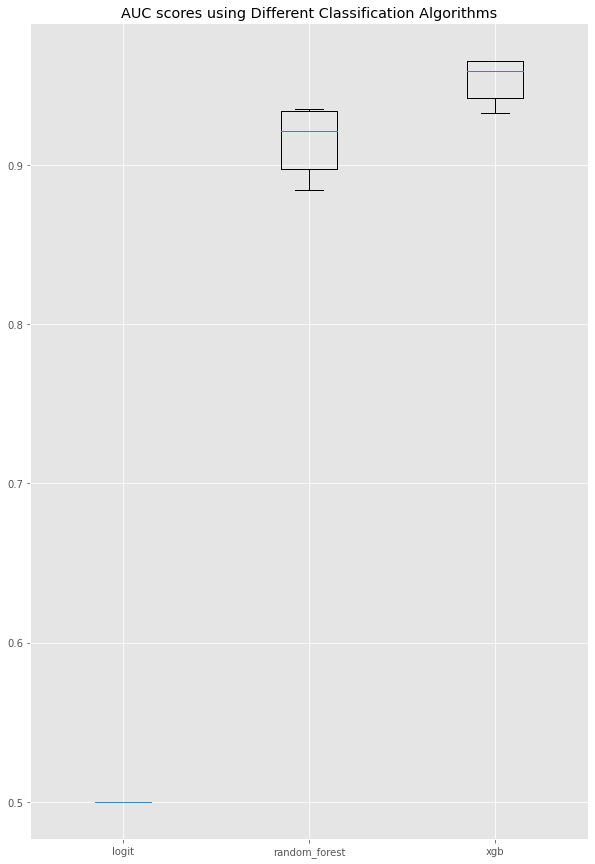

In [327]:
fig, ax = plt.subplots(figsize=(10,15))
plt.boxplot(model_cv_results.values())
ax.set_xticklabels(model_cv_results.keys())
plt.title('AUC scores using Different Classification Algorithms')
plt.savefig('C:/Users/New User/Desktop/Fraud/classifier_comparison2.png')

In [328]:
# Random Oversampling
oversamp_pipeline = imblearn.pipeline.Pipeline([('oversample', RandomOverSampler(random_state=42)),
                                                ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                      early_stopping_rounds=early_stopping_rounds,
                                                                      **initial_params))])

In [329]:
# Random Undersampling
undersamp_pipeline = imblearn.pipeline.Pipeline([('undersample', RandomUnderSampler(random_state=42)),
                                                 ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                       early_stopping_rounds=early_stopping_rounds,
                                                                       **initial_params))])

In [330]:
# Oversampling - SMOTE
smote_pipeline = imblearn.pipeline.Pipeline([('smote', SMOTE(random_state=42)),
                                             ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                   early_stopping_rounds=early_stopping_rounds,
                                                                   **initial_params))])

In [331]:
sampling_methods = {'random_oversampling': oversamp_pipeline,
                    'random_undersampling': undersamp_pipeline,
                    'smote': smote_pipeline}

In [332]:
sampling_cv_results = {}

for method, pipeline in sampling_methods.items():
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc')
    sampling_cv_results[method] = cv_results
    print(method, cv_results.mean())

[08:02:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:03:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576:

In [ ]:
# random_oversampling 0.9228205340098159
# random_undersampling 0.9329253911395883
# smote 0.8731582436434084

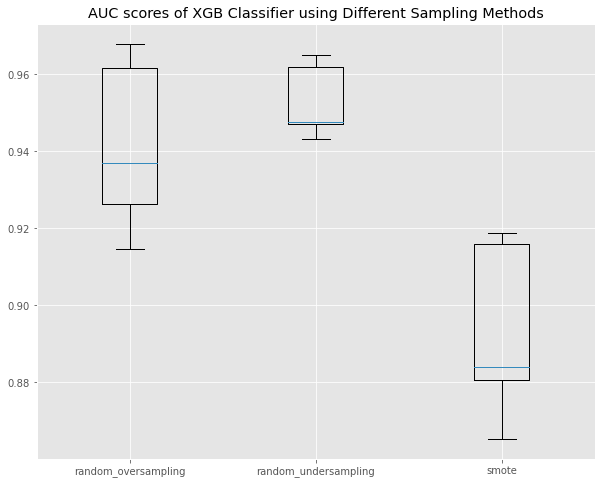

In [333]:
fig, ax = plt.subplots(figsize=(10,8))
plt.boxplot(sampling_cv_results.values())
ax.set_xticklabels(sampling_cv_results.keys())
plt.title('AUC scores of XGB Classifier using Different Sampling Methods')
plt.savefig('C:/Users/New User/Desktop/Fraud/sampling_comparison2.png')

# Bayesian Hyperparameter Tuning using Hyperopt

In [334]:
# Set up grid for hyperopt
space = {
    'max_depth': hp.quniform('max_depth', 4, 10, 2),
    'min_child_weight': hp.quniform('min_child_weight', 1, 20, 2),
    'gamma': hp.quniform('gamma', 0, 5, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
    'eta': hp.uniform('eta', 0.01, 0.3),
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

In [335]:
# Objective function
def objective(params):
    params = {'max_depth': int(params['max_depth']),
              'min_child_weight': int(params['min_child_weight']),
              'gamma': params['gamma'],
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'eta': params['eta'],
              'objective': params['objective'],
              'eval_metric': params['eval_metric']}
    
    xgb_clf = XGBClassifier(num_boost_rounds=num_boost_rounds, 
                            early_stopping_rounds=early_stopping_rounds,
                            **params)
    
    best_score = cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=5, n_jobs=3).mean()
    
    loss = 1 - best_score 
    
    return loss

In [336]:
best_result = fmin(objective, space, algo=tpe.suggest, max_evals= 20)

100%|███████████████████████████████████████████████| 20/20 [01:10<00:00,  3.53s/trial, best loss: 0.04066981091633193]


In [337]:
best_result

{'colsample_bytree': 0.8698955725712751,
 'eta': 0.09743520156906608,
 'gamma': 2.0,
 'max_depth': 10.0,
 'min_child_weight': 2.0,
 'subsample': 0.8111506465817484}

In [338]:
best_params = best_result
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
best_params['gamma'] = best_params['gamma']
best_params['colsample_bytree'] = round(best_params['colsample_bytree'], 1)
best_params['eta'] = round(best_params['eta'], 1)
best_params['subsample'] = round(best_params['subsample'], 1)
best_params

{'colsample_bytree': 0.9,
 'eta': 0.1,
 'gamma': 2.0,
 'max_depth': 10,
 'min_child_weight': 2,
 'subsample': 0.8}

# Evaluating Final Model Performance

## Train Final Model with Optimal Hyperparameters

In [339]:
final_model = imblearn.pipeline.Pipeline([('oversample', RandomOverSampler(random_state=42)),
                                                ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                      early_stopping_rounds=early_stopping_rounds,
                                                                      **initial_params))])

In [340]:
final_model = imblearn.pipeline.Pipeline([('undersample', RandomUnderSampler(random_state=42)),
                                                 ('xgb', XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                                       early_stopping_rounds=early_stopping_rounds,
                                                                       **initial_params))])

In [341]:
final_model.fit(X_train, y_train)

[08:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=10,
                               enable_categorical=False, eval_metric='auc',
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=16, num_boost_rounds=1000,
                               num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weigh

In [342]:
final_preds = final_model.predict_proba(X_test)[:,1]

In [343]:
test = pd.merge(X_test, y_test, left_index=True, right_index=True)
test.head()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
1270313,4587577161160601,89.65,4555,44.0943,-69.4828,1643,1370982115,44.999390,-68.933578,0
619381,4452366298769043,43.91,76626,32.0758,-96.7010,1563,1348172018,32.035376,-96.918475,0
1080633,4220495028289516646,92.40,92882,33.8419,-117.6043,233717,1364139974,33.223761,-118.455363,0
295044,4587657402165341815,53.08,60958,41.0646,-87.5917,2135,1337926582,41.205398,-87.792550,0
864163,4764202053279782,58.78,44412,41.0935,-81.0425,2644,1355844348,40.180619,-80.102167,0


In [344]:
df_preds = test.copy()
df_preds['fraud_score'] = final_preds

In [345]:
df_preds.head()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,fraud_score
1270313,4587577161160601,89.65,4555,44.0943,-69.4828,1643,1370982115,44.999390,-68.933578,0,0.000252
619381,4452366298769043,43.91,76626,32.0758,-96.7010,1563,1348172018,32.035376,-96.918475,0,0.000925
1080633,4220495028289516646,92.40,92882,33.8419,-117.6043,233717,1364139974,33.223761,-118.455363,0,0.000461
295044,4587657402165341815,53.08,60958,41.0646,-87.5917,2135,1337926582,41.205398,-87.792550,0,0.000336
864163,4764202053279782,58.78,44412,41.0935,-81.0425,2644,1355844348,40.180619,-80.102167,0,0.000441


In [346]:
df_preds['fraud_score'].describe()

count    25000.000000
mean         0.123917
std          0.264628
min          0.000010
25%          0.001140
50%          0.005725
75%          0.056621
max          0.999933
Name: fraud_score, dtype: float64

In [347]:
df_preds.to_csv('./final_model_preds_2.csv', index=False)

## Final Model Performance

In [348]:
roc_auc_score(y_test, final_preds)

0.9236443094083615

In [349]:
print(classification_report(y_test, final_preds.round()))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94     24855
           1       0.04      0.83      0.08       145

    accuracy                           0.90     25000
   macro avg       0.52      0.87      0.51     25000
weighted avg       0.99      0.90      0.94     25000



In [164]:
print(classification_report(y_test, final_preds.round()))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     24859
           1       0.05      0.80      0.09       141

    accuracy                           0.91     25000
   macro avg       0.52      0.86      0.52     25000
weighted avg       0.99      0.91      0.95     25000



## Final Model Feature Importances

In [350]:
explainer = shap.TreeExplainer(final_model[1])

In [351]:
shap_values = explainer.shap_values(X_test)

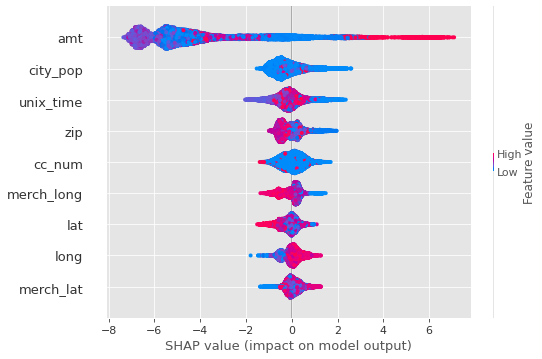

In [357]:
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig('C:/Users/New User/Desktop/Fraud/features_impt_1.png')

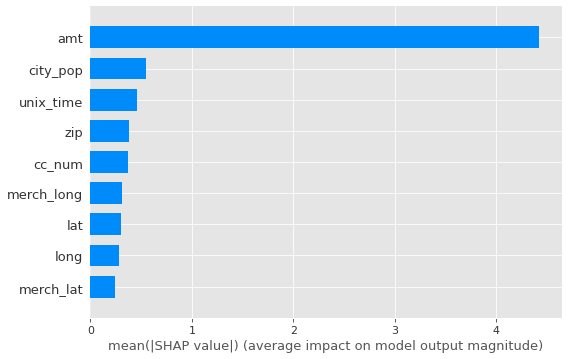

In [358]:
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.tight_layout()
plt.savefig('C:/Users/New User/Desktop/Fraud/features_impt_2_bar.png')